In [1]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import AerSimulator
import qiskit.providers.aer.noise as noise
from qiskit.visualization import plot_histogram
import copy, random, itertools
from qiskit.quantum_info.analysis import hellinger_fidelity
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# define here the distance/distribution used to unmask traitor
from scipy.spatial.distance import sqeuclidean as distance
from scipy.spatial.distance import jensenshannon as distance
from scipy.stats import hypergeom

In [3]:
# parameters
noise = True
noise_less_simulator = Aer.get_backend('qasm_simulator')

optimization_level = 3 # issues with level 2!
seed = 1946
shots = 2**13
max_rounds = 500
verbose_flag = False

# number of generals
N_gen = 4

# 2 if traitor at the source of entanglement, 0 if not
Evin = 0

# use hypergeometric distribution, or distance otherwise
hg_flag = True
flip_flag = True # for byzantine mitigation

In [4]:
hardware = False
if hardware:
    # define backend
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibm_oslo') # type here hardware backend 
    choosen_noise_model = None
else:
    # here you can change the backends
    from qiskit.providers.fake_provider import FakeCasablanca as device_3_generals
    from qiskit.providers.fake_provider import FakeCasablanca as device_4_generals    
    noise_model = None

In [5]:
# adapt to given parameters
if N_gen == 3:
    perms = list(itertools.permutations(['00','01','10'], r=3))

elif N_gen == 4:
    perms = list(itertools.permutations(['00','01','10','11'], r=4))
    
else: 
    print("only the three and four generals cases considered at this time")
    

In [6]:
if not hardware:
    if noise:
        if N_gen == 3:
            device = device_3_generals
        elif N_gen == 4:
            device = device_4_generals
        backend = AerSimulator.from_backend(device())
    else: # switch to the ideal device
        backend = noise_less_simulator

In [7]:
backend.name()

'aer_simulator(fake_casablanca)'

In [8]:
# use the simulator to get get the bitstring list

circuit = QuantumCircuit(N_gen+1+Evin)
circuit.h(circuit.qubits)

circuit.measure_active()

job = execute(circuit, backend = noise_less_simulator,shots = 2**13)
              
result = job.result()
counts = result.get_counts(circuit)

bitstrings = np.sort(list(counts.keys()))

#### Prepare the state: 


In case of three generals:

$$ \frac{1}{2\;\sqrt3}\; (\;2\;|0011\rangle - |0101\rangle - |0110\rangle - |1001\rangle -  |1010\rangle - 2\;|1100\rangle\;) $$

In case of three generals and a traitor at the source of entanglement:

$$ \frac{1}{2\;\sqrt3}\; (\;2\;|001100\rangle - |010101\rangle - |011001\rangle - |100110\rangle -  |101010\rangle + 2\;|110011\rangle\;) $$

In case of four generals:

$$(\sqrt6|00111\rangle +  |01001\rangle +  |01010\rangle + |01100\rangle + |10011 \rangle +  |10101\rangle +  |10110\rangle +  \sqrt6|11000\rangle) \ /\sqrt18$$

In [9]:
if N_gen == 3:
    init_list = np.array([0., 0., 0., 2., 0., -1., -1., 0.,
             0., -1., -1., 0., 2., 0., 0., 0.]) / ( 2*np.sqrt(3) )
    
elif N_gen + Evin  == 4:
    init_list = np.array(  [0., 0., 0., 0., 0., 0., 0., 6.**.5,
                            0., +1., +1., 0., +1., 0., 0., 0.,
                            0., 0., 0., +1., 0., +1., +1., 0.,
                            6.**.5, 0., 0., 0., 0., 0., 0., 0.]) / np.sqrt(18)    
elif N_gen + Evin  == 6:
    init_list = np.array(
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
      2.449489742783178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
      0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
      0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
      0.0, 0.0, 0.0, 0.0, 2.449489742783178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
      0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ) / np.sqrt(18)  
        

In [10]:
alice = QuantumRegister(2, 'alice')
bob = QuantumRegister(1, 'bob')
carol = QuantumRegister(1, 'carol')
dave = QuantumRegister(1, 'dave')
evin = QuantumRegister(2, 'evin')

# create the quantum circuit
if N_gen + Evin  == 3 :
        circuit = QuantumCircuit(alice, bob, carol)
        circuit.initialize(init_list)
    
if N_gen + Evin  == 5 :
        circuit = QuantumCircuit(alice, bob, carol, evin)
        circuit.initialize(init_list, [0,1,2,3] )
        circuit.barrier()
        circuit.cx(0,4)
        circuit.cx(1,5)

elif N_gen == 4:
    if Evin == 0:
        circuit = QuantumCircuit(alice, bob, carol, dave)
        circuit.initialize(init_list)
    
    if Evin == 2:
        circuit = QuantumCircuit(alice, bob, carol, dave, evin)
        circuit.initialize(init_list) 
        #circuit.barrier()
        #circuit.cx(0,5)
        #circuit.cx(1,6)

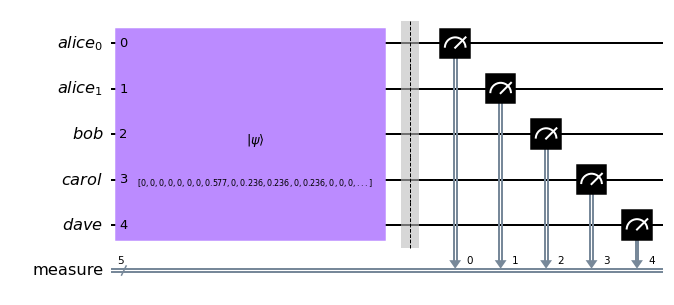

In [11]:
# add Pauli-Z measurements and draw the circuit
circuit.measure_active()
circuit.draw(output='mpl')

In [12]:
# if more details are requested (more .decompose() may be added)
#qasm_circuit = circuit.decompose().decompose() 
#qasm_circuit.draw(output='mpl', fold = 20 - N_gen , plot_barriers=False,
                  #style = {'backgroundcolor': 'cyan'})                                             

## game functions

In [13]:
# byzantine traitor game serving function

def play(k_list, t_list, n_its_list, used_list, stop_flag, flag_y = None):
    flag_1 = True
    flag_2 = True
    
    retry = True
    while retry:
        k = k_list[-1]
        if k in used_list:
            k_list.pop()
            if k_list == []: 
                stop_flag = True
                return flag_1, flag_2
        else:
            retry = False
            used_list.append(k)
    
    if k in t_list:
        flag_1 = False

    if n_its_list[k] == flag_y: 
        flag_2 = False

    return flag_1, flag_2

In [14]:
def traitor_game(players, verbose = False):
    # start playing
    
    game_rounds = 0
    toss = random.randrange(2)
    head = tail = 0
    gen[players[toss]]['failed'] = 0
    gen[players[1-toss]]['failed'] = 0
    
    mat_t = gen[players[toss]]['mat']
    n_its_toss = n_its[mat_t:mat_t+1][0]
    mat_nt = gen[players[1-toss]]['mat']
    n_its_notoss = n_its[mat_nt:mat_nt+1][0]
    
    flag = np.ones((2, 2), dtype=bool)
    used_list = []
    stop_flag = False
    print("\nByzantine traitor game. First to play is", gen[players[toss]]['name'])
    print("                        Second to play is", gen[players[1-toss]]['name'])    
    
    if verbose:
        print( "shots:", shots )
        print(len(gen[players[toss]]['k_list']), "in "  + gen[players[toss]]['name'] + ' list:', 
                   sorted(gen[players[toss]]['k_list']) )   
        print(len(gen[players[1-toss]]['k_list']), "in "  + gen[players[1-toss]]['name'] + ' list:', 
                   sorted(gen[players[1-toss]]['k_list']) )    
    
    while len(gen[players[toss]]['k_list']) > 0 and game_rounds < max_rounds\
            and len(gen[players[1-toss]]['k_list']) > 0 and not stop_flag:
        
        game_rounds += 1        
        
        # first to play
        flag[0][1], flag[1][1] = play(gen[players[toss]]['k_list'],
                                   gen[players[1-toss]]['t_list'],
                                   n_its_notoss, used_list, stop_flag,
                                      gen[players[toss]]['flag_y'])
        
        if not flag[0][1] or not flag[1][1]:                          
            head +=1
        
        gen[players[toss]]['k_list'].pop()

        # second to play
        if not stop_flag: 
            
            flag[0][0], flag[1][0] = play(gen[players[1-toss]]['k_list'],
                                       gen[players[toss]]['t_list'],
                                       n_its_toss, used_list, stop_flag,
                                          gen[players[1-toss]]['flag_y'])

            if not flag[0][0] or not flag[1][0]:                                     
                tail += 1

            gen[players[1-toss]]['k_list'].pop()    
    
    if verbose:
        print(len(used_list), "ind in used_list", sorted(used_list) ) 
    
    print("rounds:", game_rounds)
    
    print(gen[players[1-toss]]['name'] + " counted that " +\
           gen[players[toss]]['name'] + " failed " + str(head)\
           + " times: " + "{:.0%}".format(head / game_rounds))
              
    
    print(gen[players[toss]]['name'] + " counted that " +\
           gen[players[1-toss]]['name'] + " failed " + str(tail)\
           + " times: " + "{:.0%}".format(tail / game_rounds))
    
    return game_rounds, head, tail, toss

## Start experiments
### distribute entaglement

In [15]:
# distribute entanglement 
if noise:
    job_ideal = execute(circuit, backend = noise_less_simulator,
                        shots = shots,                
                        optimization_level = optimization_level)
    
    res_ideal = job_ideal.result()
    counts_ideal = res_ideal.get_counts(circuit)

    if shots <= 200: # for checks
        verbose_flag = True

    if N_gen == 3:    
        job = execute(circuit, backend = backend, shots = shots,
        memory=True,     
        optimization_level = optimization_level)
        figsize = (14,7)
        
    elif N_gen == 4:
        job = execute(circuit, backend = backend, shots = shots,
        #noise_model = noise_model,              
        memory=True,
        optimization_level = optimization_level,
        seed = 1946) #19476) #1948)
        
        figsize = (10,6) 
   
    else: 
        job = None
        print("only the three and four generals cases considered at this time")

    results = job.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [noise_less_simulator, backend.name()]
    counts_to_plot = [counts_ideal,counts]
    print('hellinger fidelity: {:.1%}'.format(
        hellinger_fidelity(counts_ideal,counts)))
else:
    job_ideal = execute(circuit, backend = backend, shots = shots,
                        memory = True,
                        optimization_level = optimization_level)
    results = job_ideal.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    counts_ideal = counts
    legend_to_plot = [backend.name()]
    counts_to_plot = [counts]
    figsize = None   

hellinger fidelity: 64.8%


###   check if the entangled states are not corrupt
 
Mutual verification.

In this phase, the parties can make a prediction of game error rates in function of the device, the circuit, the order, the lieutenant, and his loyalty. This shared knowledge is first used to determine the optimal lengths of Alice's lists, in order that a traitorous lieutenant has the lower probability of success in the game.  At the end, the  discrimination between commanding general or lieutenant as traitor is also improved.

In [16]:
# define staff

gen = { 'A': { "mat" : 0, 'name': 'Alice'}, 
        'B': { "mat" : 1, 'name': 'Bob'},
        'C': { "mat" : 2, 'name': 'Carol'} }
if N_gen == 4 :       
        gen['D'] = { "mat" : 3,'name': 'Dave'} 

In [17]:
# take a part of the results for check
frac_kept = 1/2 # fraction used for the game
check_i = list(range(shots))
random.shuffle(check_i)
check_i = check_i[:int(shots*(1-frac_kept))]

In [18]:
check_mem = []
for i, index in enumerate(check_i):
    check_mem.append(memory[index])
c_dict = {item:check_mem.count(item) for item in check_mem}
if noise:
    print('hellinger fidelity: {:.1%}'.format(
        hellinger_fidelity(counts_ideal,c_dict))) 

hellinger fidelity: 64.3%


In [19]:
used_mem = []
for i, index in enumerate(set(list(range(shots))) - set(check_i)):
    used_mem.append(memory[index])
u_dict = {item:used_mem.count(item) for item in used_mem}
print('hellinger fidelity: {:.1%}'.format(
        hellinger_fidelity(counts_ideal,u_dict))) # WIP

hellinger fidelity: 65.2%


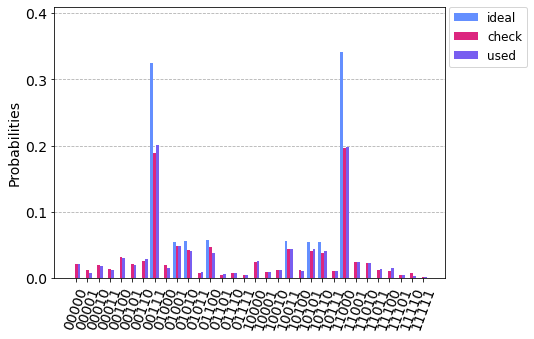

In [20]:
legend_to_plot = ["ideal", "check", "used"]
counts_to_compare = [counts_ideal,c_dict, u_dict]
plot_histogram(counts_to_compare, bar_labels = False,
                   legend = legend_to_plot)

In [21]:
def flip(binary_str):    
    return ''.join('0' if i == '1' else '1' for i in binary_str)

In [22]:
# Byzantine mitigation
if flip_flag:
    bit_strings = []
    for i, bitstring in enumerate(memory):
        if i%2:
            bit_strings.append(flip(bitstring))
        else:
            bit_strings.append((bitstring))
else:
    bit_strings = memory

In [23]:
# get an array for gaming
n_its = np.zeros((N_gen + int(Evin/2), int(shots*frac_kept))).astype(int)

# convert bitstrings to n_its and store them 

v_dic = {'00': 0, '01': 2,  '10': 2,  '11' : 1, '0' :  0, '1' : 1}

game_i = -1
for j, bitstring in enumerate(bit_strings):
    if j not in check_i:
        game_i += 1
        n_its[0][game_i] = v_dic[bitstring[0:2]] # Alice
        n_its[1][game_i] = v_dic[bitstring[2:3]] # Bob
        n_its[2][game_i] = v_dic[bitstring[3:4]] # Charlie
        if N_gen == 4:
            n_its[3][game_i] = v_dic[bitstring[4:5]] # Dave
        if Evin == 2:
            n_its[N_gen][game_i] = v_dic[bitstring[N_gen+1:N_gen+3]] # Evin
            

In [24]:
# get an array for testing
n_its_t = np.zeros((N_gen + int(Evin/2), int(shots*(1-frac_kept)))).astype(int)

# convert bitstrings to n_its_t and store them 

v_dic = {'00': 0, '01': 2,  '10': 2,  '11' : 1, '0' :  0, '1' : 1}

game_i = -1
for j, bitstring in enumerate(bit_strings):
    if j in check_i:
        game_i += 1
        n_its_t[0][game_i] = v_dic[bitstring[0:2]] # Alice
        n_its_t[1][game_i] = v_dic[bitstring[2:3]] # Bob
        n_its_t[2][game_i] = v_dic[bitstring[3:4]] # Charlie
        if N_gen == 4:
            n_its_t[3][game_i] = v_dic[bitstring[4:5]] # Dave
        if Evin == 2:
            n_its_t[N_gen][game_i] = v_dic[bitstring[N_gen+1:N_gen+3]] # Evin
    

In [25]:
# for histo article
 # n_its_t_c[game_i]  =       

In [26]:
# game-error prediction on the test fraction

lnt_list = list(range(N_gen-1))
lnt_permutations = list(itertools.permutations(lnt_list, r=2))
n_success = np.ones( (N_gen-1, N_gen-1, 2, 3) )
n_trial = np.ones( (N_gen-1, N_gen-1, 2, 3) )

for j in range(len(n_its_t[0])):
    #print(j, n_its_t)n_its_t[0]
    if j in check_i:
        for pair in lnt_permutations:            
            for order in range(2):
                # honest lieutenant 
                if n_its_t[0][j] == order:
                    n_trial[pair[0], pair[1], order, 0] += 1
                    if n_its_t[pair[0]+1][j] == 1-order:
                        n_success[pair[0], pair[1], order, 0] += 1
                # traitor        
                else:
                    if n_its_t[pair[1]+1][j] == order:
                        n_trial[pair[0], pair[1], order, 1] += 1
                        if n_its_t[pair[0]+1][j] == order:
                            n_success[pair[0], pair[1], order, 1] += 1   

                    elif n_its_t[pair[1]+1][j] == 1-order:    
                        n_trial[pair[0], pair[1], order, 2] += 1                
                        if n_its_t[pair[0]+1][j] == order:
                            n_success[pair[0], pair[1], order, 2] += 1                   

                            
p = n_success/n_trial
q = 1 - p

In [27]:
# determine the optimal lengths of Alice's lists 
# (only for the case of 3 generals)
if N_gen == 3:
    n_out = np.zeros((2, 2))
    for ln in range(0,2):
        for order in range(2):
            n_out[ln, order] = n_trial[1-ln, ln, order, 2] \
              * (p[1-ln, ln, order, 1] - p[1-ln, ln, order, 2]) \
              / (q[1-ln, ln, order, 0] - p[1-ln, ln, order, 1])
    n_out_m = np.round(np.mean(n_out, axis=0) * (frac_kept)/(1-frac_kept)).astype(int)

    # check: compute expected traitor error after optimized Alice's trit-list length
    new_p = np.zeros((2, 2))
    old_p = np.zeros((2, 2))
    n_check = np.round(np.mean(n_out, axis=0)) # mean because Alice doesn't now who is the traitor
    for ln in range(0,2):
        for order in range(2):
            old_p [ln, order] = p[1-ln, ln, order, 1] # traitor uses only one trit favour 
            new_p[ln, order] = (n_success[1-ln, ln, order, 1] + n_success[1-ln, ln, order, 2] \
                                     + q[1-ln, ln, order, 0] * n_check[order]) \
                                     / (n_trial[1-ln, ln, order, 1] + n_trial[1-ln, ln, order, 2] \
                                     + n_check[order]) # the mix of favours has now same error rate
    
    print(new_p - old_p)  # must be small
elif N_gen == 4:
    n_out_m = np.full((2, 2), 0)  #max_rounds)


In [28]:
# prepare an error-rate dictionary for the agreement phase

pair_list = []
gen_list = []
for key in list(gen.keys())[1:N_gen]:
    gen_list.append(key)
for pair in list(itertools.permutations(gen_list, r=2)):
    pair_list.append(str(pair[0]) + str(pair[1]))     

predict = {}
for i, pair in enumerate(lnt_permutations): 
      predict[pair_list[i]] = [q[pair[0]][pair[1]][0][0],
                               q[pair[0]][pair[1]][1][0],
                               q[pair[0]][pair[1]][0][1],
                               q[pair[0]][pair[1]][1][1] ]

In [29]:
# for hypergeometric distribution
n_failure = n_trial - n_success
n_hg = {}
for i, pair in enumerate(lnt_permutations):  
    n_hg[pair_list[i]] = [int(x) for x in 
    [n_failure[pair[0]][pair[1]][0][0],
    n_failure[pair[0]][pair[1]][1][0],
    n_failure[pair[0]][pair[1]][0][1],
    n_failure[pair[0]][pair[1]][1][1] ] ]

M_hg = {}
for i, pair in enumerate(lnt_permutations): 
      M_hg[pair_list[i]] = [int(x) for x in 
        [n_trial[pair[0]][pair[1]][0][0],
        n_trial[pair[0]][pair[1]][1][0],
        n_trial[pair[0]][pair[1]][0][1],
        n_trial[pair[0]][pair[1]][1][1] ] ]

In [30]:
if flip_flag:    
    for v in n_hg.values():
        v[0] = v[1] = v[0] + v[1]
        v[2] = v[3] = v[2] + v[3]

    for v in M_hg.values():
        v[0] = v[1] = v[0] + v[1]
        v[2] = v[3] = v[2] + v[3]

In [31]:
def hpg_pmf(M, n, N, x):
    return hypergeom(M, n, N).pmf(x)

In [32]:
def hypergeom_plot(M, n, N):
    
    '''
    Visualization of Hypergeometric Distribution for given parameters
    :param M: population size
    :param n: total number of desired items in N
    :param N: number of draws made from N
    :returns: Plot of Hypergeometric Distribution for given parameters
    '''
    
    x = np.arange(0, n+1)
    y = [hpg_pmf(M, n, N, x) for x in range(n+1)]
    #plt.plot(x, y, 'bo')
    plt.vlines(x, 0, y, lw=2)
    plt.xlabel('# of desired items in our draw')
    plt.ylabel('Probablities')
    plt.title('Hypergeometric Distribution Plot')
    plt.show();

In [33]:
def hypergeom_one_plot(M, n, N, color, label):
    x = np.arange(0, N+1)
    y = [hpg_pmf(M, n, N, x) for x in range(N+1)]
    plt.vlines(x, 0, y, lw=2, color = color,  alpha=0.2, label = label)
    return max(y)
        
def hypergeom_biplot(M_tr, n_tr, M_no, n_no, N_hg, x_hg,
                     receiver = "Receiver", sender = 'Sender'):        
    
    max_y2 = hypergeom_one_plot(M_no, n_no, N_hg, "g", "expected if loyal")
    max_y1 = hypergeom_one_plot(M_tr, n_tr, N_hg, "r", "expected if traitorous") 
    
    plt.vlines(x_hg, 0, max (max_y1, max_y2),
               'b', 'dashed', label = "observed")
    plt.legend()
    plt.xlabel('number of errors')
    plt.ylabel('conditionnal probabilities')
    plt.suptitle('Hypergeometric Distributions')
    plt.title(receiver + " Testing " + sender)
    fig = plt.figure()
    fig.set_size_inches(15,21)
    plt.show();

In [34]:
# prior probability to be a traitor: flat prior
pi_dict = { 'BC': [.5, .5, .5, .5], 'BD': [.5, .5, .5, .5], 'CB': [.5, .5, .5, .5], 
           'CD': [.5, .5, .5, .5], 'DB': [.5, .5, .5, .5], 'DC': [.5, .5, .5, .5] }

### use the results to solve the problem

In [35]:
# define scenario

gen['A']['faithful'] = False
gen['A']['target'] = None

gen['B']['faithful'] = True
gen['B']['target'] = True

gen['C']['faithful'] = False
gen['C']['target'] = False
if N_gen == 4 :       
    gen['D']['faithful'] = True
    gen['D']['target'] = False

In [36]:
# check here the number of traitors
 
for key in list(gen.keys())[1:N_gen]:
    if not gen[key]['faithful'] and gen[key]['target']:           
        print("A lieutenant cannot be traitor himself and target of a traitorous commander") 
        print("Please correct the scenario")

traitor_counter = 0
for key in list(gen.keys())[0:N_gen]:    
    if not gen[key]['faithful']:
        traitor_counter += 1

print("Scenario with " + str(N_gen) + " generals and " + str(traitor_counter) + " traitor(s)")

if traitor_counter > N_gen -2 :
    print("No more than " + str(N_gen-2) + " traitor(s) allowed for "\
          + str(N_gen) + " generals, even with quantum power") 
    print("Please correct the scenario")    

Scenario with 4 generals and 2 traitor(s)


Scenario run on aer_simulator(fake_casablanca)
generals: ['Alice', 'Bob', 'Carol', 'Dave']
faithful:   [False, True, False, True]
  target:   [None, True, False, False]

Order is to attack

Byzantine traitor game. First to play is Bob
                        Second to play is Dave
rounds: 500
Dave counted that Bob failed 98 times: 20%
Bob counted that Dave failed 59 times: 12%

Byzantine traitor game. First to play is Carol
                        Second to play is Dave
rounds: 500
Dave counted that Carol failed 181 times: 36%
Carol counted that Dave failed 88 times: 18%

No game between Bob and Carol
They say they got the same order from Alice


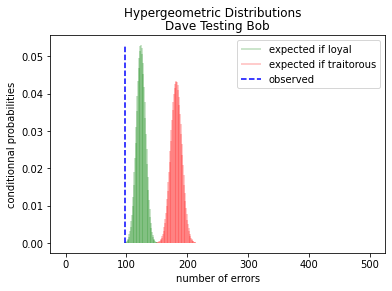

<Figure size 1080x1512 with 0 Axes>

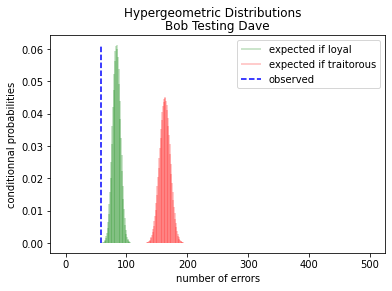

<Figure size 1080x1512 with 0 Axes>

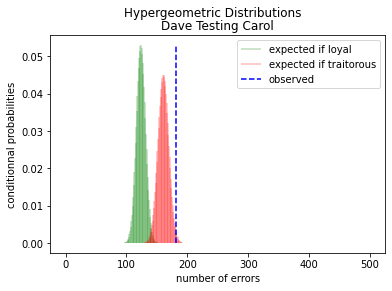

<Figure size 1080x1512 with 0 Axes>

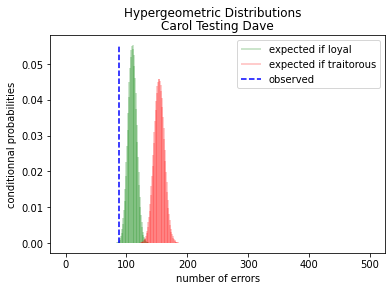

<Figure size 1080x1512 with 0 Axes>


Final agreement:

Carol and Alice are traitors
Bob and Dave follow the order received by Dave


In [37]:
# Alice determine the message: 0 for retreat, 1 for attack
m = 1
max_rounds = 500
print("Scenario run on " + backend.name())
print("generals:", list(map(lambda v: v["name"],gen.values()))[0:N_gen])
print("faithful:  ", list(map(lambda v: v["faithful"],gen.values()))[0:N_gen])
print("  target:  ", list(map(lambda v: v["target"],gen.values()))[0:N_gen])

if Evin == 2:
    print("backdoor at entanglement phase")
else:
    print()

if m == 1:
    print("Order is to attack")
else :
    print("Order is to retreat")

gen['A']['message'] = m
# Alice establishes the corresponding list of indices 
# and the corresponding cheating list

j_list_A = []
j_list_Ac = []
mat = gen['A']['mat']
for k in range(int(shots*frac_kept)):
    val_it = n_its[mat:mat+1][0][k]
    if val_it == m:
        j_list_A.append(k)
    
    elif val_it == 1 - m:
        j_list_Ac.append(k)

# optimal lengths of Alice's list
#cut_point = min([ len(j_list_A) - max_rounds,
#                  len(j_list_Ac) - max_rounds])
cut_point = min( [max_rounds, len(j_list_A), len(j_list_Ac)] ) 
if N_gen == 3: 
    cut_point = min( [ max_rounds,  
                  len(j_list_A) - n_out_m[m],
                  len(j_list_Ac) - n_out_m[1-m] ])
    
random.shuffle(j_list_A)
j_list_A = j_list_A[0:cut_point]

random.shuffle(j_list_Ac)
j_list_Ac = j_list_Ac[0:cut_point]

j_list_A.sort()
j_list_Ac.sort()

gen['A']['j_list'] = copy.deepcopy(j_list_A)

# Alice send her messages and corresponding lists 
# by pairwise authenticated classical and quantum channels

for key in list(gen.keys())[1:N_gen]:
    if (not gen['A']['faithful']) and gen[key]['target']:
        gen[key]['message'] = 1 - m    
        gen[key]['j_list'] = copy.deepcopy(j_list_Ac )
    else:
        gen[key]['message'] = m    
        gen[key]['j_list'] = copy.deepcopy(j_list_A) 
            
for key in list(gen.keys())[1:N_gen]:
    #if gen[key]['faithful']:
    gen[key]['flag_y'] = gen[key]['message']
    #else:    
        #gen[key]['flag_y'] = 1 - gen[key]['message']

# to track anomalies    
mtx_honest = np.full((N_gen-1, N_gen-1), True, dtype=bool)    
    
# lists used in the game:

for i, key in enumerate(list(gen.keys())[1:N_gen]):
    if gen[key]['faithful']:
        # loyal lieutenant uses provided commander list in game
        gen[key]['t_list'] = copy.deepcopy(gen[key]['j_list'])
    
    else:
        
        gen[key]['flag_y'] = 1 - gen[key]['flag_y']
            
        mtx_honest[i,i] = False # for tracking anomalies
        
        if Evin == 2: # Evin briefed traitorous lieutenant:          
            gen[key]['t_list'] = np.where( n_its[N_gen] == gen[key]['flag_y'] )[0].tolist()
    
        else:
            # traitorous lieutenant uses complement of commander's list in game (no other choice)
            gen[key]['t_list'] = []
            tot_list = list( set(range(int(shots*frac_kept))) - set(gen[key]['j_list']) )
            for i, index in enumerate(tot_list):
                if n_its[gen[key]['mat']][index] == 1 - gen[key]['flag_y']:
                    gen[key]['t_list'].append(index)
                
# prepare for treator game

p_list = []
    
for key in list(gen.keys())[1:N_gen]:

    # add to player's list:            
    if gen[key]['flag_y'] != 3: 
        p_list.append(key)

# check if treator game possible
if len(p_list) == 1:
    print("Only one lieutenant has consistent order") 

elif len(p_list) == 0:
    print("No lieutenant has consistent order")
    
else: # treator game:
    
    res_traitor = {}
    res_N_hg = {}
    res_x_hg = {}
    
    # game between players claiming different received order
    for players in list(itertools.combinations(p_list, r=2)):       
        
        if gen[players[0]]['flag_y'] != gen[players[1]]['flag_y']:
            
            # prepare indices list                
            for key in players:                  
                mat = gen[key]['mat']

                gen[key]['k_list'] = [] 
                
                for k in range(int(shots*frac_kept)):
                    n_it = n_its[mat:mat+1][0][k]                        
                    if (k in gen[key]['t_list']):
                        if gen[key]['faithful'] or N_gen == 3\
                          or (N_gen == 4 and n_it == 1 - gen[key]['flag_y']):
                            gen[key]['k_list'].append(k)
                        
                random.shuffle(gen[key]['k_list'])
                      
            # play the game:   
            game_rounds, head, tail, toss = traitor_game(players, verbose_flag)
            
            # for use of distances
            res_traitor[players[1-toss] + players[toss]] = head / game_rounds
            res_traitor[players[toss] + players[1-toss]] = tail / game_rounds
            
            # for use of hypergeometric distributions
            res_N_hg[players[1-toss] + players[toss]] = game_rounds
            res_N_hg[players[toss] + players[1-toss]] = game_rounds
            res_x_hg[players[1-toss] + players[toss]] = head
            res_x_hg[players[toss] + players[1-toss]] = tail
            
    # no game between players claiming identical received order: last check
    for players in list(itertools.combinations(p_list, r=2)):
        
        if gen[players[0]]['flag_y'] == gen[players[1]]['flag_y']:
            
            print("\nNo game between " + gen[players[0]]['name'] + " and " + gen[players[1]]['name']\
                  + "\nThey say they got the same order from " + gen['A']['name'])
                        
            if gen[players[0]]['j_list'] == gen[players[1]]['j_list']:
                res = 0
            
            else:
                res = 1
                print("WARNING: different lists received from " + gen['A']['name'])
            
            res_traitor[players[0] + players[1]] = res
            res_traitor[players[1] + players[0]] = res
            
                               
    # identify traitors from game results   
    traitor = []
    discoverer = []
    trustable = [] 
    
    for i, (ltnnts, obs_err) in enumerate(res_traitor.items()):
            L0 = gen[ltnnts[0]] 
            L1 = gen[ltnnts[1]] 
            if L1['flag_y'] != L0['flag_y']: # there was a game                
                
                if hg_flag:
                    # for use of hypergeometric distributions tr = traitor, no = not traitor
                    M_tr = M_hg[ltnnts][2 + 1 - L1['flag_y']] 
                    n_tr = n_hg[ltnnts][2 + 1 - L1['flag_y']] 
                    M_no = M_hg[ltnnts][L1['flag_y']]
                    n_no = n_hg[ltnnts][L1['flag_y']]
                    N_hg = res_N_hg[ltnnts]
                    x_hg = res_x_hg[ltnnts]
                    
                    hypergeom_biplot(M_tr, n_tr, M_no, n_no, N_hg, x_hg,L0['name'], L1['name'])
                    
                    p_tr = hpg_pmf(M_tr, n_tr, N_hg, x_hg)
                    p_no = hpg_pmf(M_no, n_no, N_hg, x_hg)
                    pi_tr =  pi_dict[ltnnts][2 + L1['flag_y']] # L1['pi_t'] in previous version #WIP
                    pi_no =  pi_dict[ltnnts][L1['flag_y']]    # gen['A']['pi_t'] in previous version
                    # Bayes formula:
                    p_post_tr = pi_tr * p_tr / (pi_tr * p_tr + pi_no * p_no)
                    #print(ltnnts, pi_no, pi_tr, p_no, p_tr, 1. - p_post_tr, p_post_tr)
                    caution = p_post_tr >= .5                        

                else:
                    # for use of distances:
                    err_expected = predict[ltnnts][L1['flag_y']]
                    err_exaggerated =  predict[ltnnts][2 + L1['flag_y']]
                    expected = [err_expected, 1. - err_expected]
                    exaggerated = [err_exaggerated, 1. - err_exaggerated]
                    observed = [obs_err, 1. - obs_err]
                    caution = distance(exaggerated, observed) < distance(expected, observed)                    

                mtx_honest[L0['mat']-1][L1['mat']-1] = caution

                if caution:
                    traitor.append(L1['name'])
                    discoverer.append(L0['name'])

                else:
                    trustable.append(L1['name'])
                             
    # final agreement
    print("\nFinal agreement:\n")
    
    list_t = list(OrderedDict.fromkeys(traitor))
    list_h = list(OrderedDict.fromkeys(trustable))
    list_d = list(OrderedDict.fromkeys(discoverer))
    nbt = len(list_t)  # number of lieutenants who are traitor
    nbh = len(list_h)  # number of lieutenants who are honest
    nbd = len(list_d)  # number of lieutenants who discovered a traitor
    
    if nbh == 0  and nbd == 0 and nbt == 0: # No game occured OK
        print("No traitor detected")
        print("All lieutenants follow "+ gen['A']['name'] +"'s order")
            
    elif nbh == N_gen - 1 and nbd == 0 and nbt == 0: # 1C OK
        print(gen['A']['name'] +" is a traitor")
        if N_gen == 3:
            print(list_h[0] + " and " + list_h[1] + \
                  " agree with a common strategy")        
        elif N_gen == 4:            
            print(list_h[0] + ", " + list_h[1] + " and "\
                  + list_h[2] + " follow a majority strategy")
    
    elif nbh == N_gen - 2 and nbd == N_gen - 2 and nbt == 1: # 1L OK
        print(list_t[0] + " is a traitor")
        if N_gen == 3:
            print(list_h[0] + " follows "+ gen['A']['name'] +"'s order")        
        elif N_gen == 4:            
            print(list_h[0] +" and "+ list_h[1] +\
                  " follow "+ gen['A']['name'] +"'s order")
            
    elif nbh == N_gen - 3 and nbd == N_gen - 3 and nbt == 2: # 2L OK
        print(list_t[0] + " and " + list_t[1] + " are traitors")
        print(list_h[0] + " follows "+ gen['A']['name'] + "'s order")
    
    elif nbh == N_gen - 2 and nbd == 1 and nbt == 1: #1L + 1C  OK 
        print(list_t[0] + " and " + gen['A']['name'] + " are traitors")
        print(list_h[0] + " and " + list_h[1] +\
              " follow the order received by "+ list_d[0])

    else:
        print("Something wrong")
        print(mtx_honest)    